In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bp
%matplotlib inline

In [3]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_20s_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)

In [4]:
data_set[:10]

,bid,ask
2018-01-01 23:58:00,1.20093,1.20115
2018-01-01 23:58:20,1.20082,1.20111
2018-01-01 23:58:40,1.20043,1.20110
2018-01-01 23:59:00,1.20015,1.20110
2018-01-01 23:59:20,1.20028,1.20110
2018-01-02 00:00:00,1.20015,1.20110
2018-01-02 00:00:40,1.20015,1.20105
2018-01-02 00:01:00,1.20030,1.20112
2018-01-02 00:01:20,1.20030,1.20115
2018-01-02 00:03:00,1.20026,1.20083


In [5]:
# %load ../code/build_dataset.py
def build_dataset(df, window, binary_target=False, delete_constant_values=True, PNL=False):
    """
    función para construir un data set
    window: tamaño de la ventana a utilizar para construir el dataset
    df: dataframe, con columna bid y ask.
    binary_target: si desea clasificar, este arroja 2 si el valor se mantiene,
    1 si el valor sube y 0 si este baja.
    delete_constant_values: default: True, elimina los valores que se mantienen
    
    retorna:
    X: dataset, con columna de PNL si así se especifica(default: False)
    y: target
    bt: binary target, default: False
    """

    import pandas as pd
    import numpy as np
    result = []
    binary = [] #para la columna objetivo binaria
    pnl_buy = [] #almacenar el pnl en caso de compra
    pnl_sell = [] #almacenar el pnl en caso de venta
    signal = df.bid
    ask = df.ask
    indx = signal.index[window-1:-1] #se toman los indicen que quedarán al final
    for i in range(len(signal)-window):
        
        if delete_constant_values == True:
            if signal[i+window] != signal[i+window-1]:

                result.append(signal[i: i + window+1])
                if PNL == True: 
                    pnl_sell.append(signal[i+window-1] - ask[i+window]) #calcular pnl en caso de venta-compra
                    pnl_buy.append(signal[i+window] - ask[i+window-1]) #calcular pnl en caso de compra-venta
                
                if binary_target == True:
                    if signal[i+window] < signal[i+window-1]: 
                        if (signal[i+window-1] - ask[i+window]) > 0: binary.append(0) # 0 si baja y gano
                        else: binary.append(2) # 2 si baja pero pierdo
                            
                    if signal[i+window] > signal[i+window-1]: # 1 si sube
                        if (signal[i+window] - ask[i+window-1]) > 0: binary.append(1) # 1 si sube y gano
                        else: binary.append(3) # 3 si sube pero pierdo
                        
            else: indx = indx.delete(len(result))
                
        else:

            result.append(signal[i: i + window+1])
            if PNL == True:
                pnl_sell.append(signal[i+window-1] - ask[i+window]) #calcular pnl en caso de venta-compra
                pnl_buy.append(signal[i+window] - ask[i+window-1]) #calcular pnl en caso de compra-venta
            
        if binary_target == True and delete_constant_values == False:
            if signal[i+window] == signal[i+window-1]: binary.append(4) # 4 si se mantiene
                
            if signal[i+window] < signal[i+window-1]:
                if (signal[i+window-1] - ask[i+window]) > 0: binary.append(0) # 0 si baja y gano
                else: binary.append(2) # 2 si baja pero pierdo
                    
            if signal[i+window] > signal[i+window-1]:
                if (signal[i+window] - ask[i+window-1]) > 0: binary.append(1) # 1 si sube y gano
                else: binary.append(3) # 3 si sube pero pierdo
    
    data = pd.DataFrame(np.array(result), index=indx)
    y = np.array(data.iloc[:,window])
    data = data.drop(window,axis=1)
    if PNL == True:
        data['PNL_0'] = pnl_sell
        data['PNL_1'] = pnl_buy 
    if binary_target == True: return data, y, np.array(binary)
    else: return data, y

In [18]:
# %load ../code/PNLEstimatorWrapper.py
import pandas as pd
import numpy as np
class PNLEstimatorWrapper:
    
    def __init__(self, estimator, PNL_column, exclude_PNL_column_from_training=True):
        self.estimator = estimator
        self.PNL_column = PNL_column
        self.exclude_PNL_column_from_training = exclude_PNL_column_from_training
        
    def fit(self, X, y):
        assert 'PNL_1' and 'PNL_0' in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column[0] and col!=self.PNL_column[1]]]
        self.estimator.fit(X,y)
        
    def predict(self, X):
        assert 'PNL_1' and 'PNL_0' in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column[0] and col!=self.PNL_column[1]]]
        return self.estimator.predict(X)
    
    def score(self, X, y):
        pnl_1 = X.PNL_1
        pnl_0 = X.PNL_0
        pre = self.predict(X)
        r = sum((pre==1)*pnl_1 + (pre==0)*pnl_0)
        sell = sum(pre==0) + sum(pre==2)
        buy = sum(pre==1) + sum(pre==3)
        #percent_0 = np.mean(y==pre)*100
        percent_1 = np.mean((pre==1)*(y==1)) # si sube y gano
        percent_0 = np.mean((pre==0)*(y==0)) # si baja y gano
        percent_3 = np.mean((pre==3)*(y==3)) # si sube y pierdo
        percent_2 = np.mean((pre==2)*(y==2)) # si baja y pierdo
        
        count_ones, count_zeros = 0,0
        l_one, l_zero = [],[]
        for i in pre:
            if i==1:
                l_zero.append(count_zeros)
                count_zeros = 0
                count_ones += 1
            else:
                l_one.append(count_ones)
                count_zeros += 1
                count_ones = 0
        l_zero.append(count_zeros)
        l_one.append(count_ones)
        
        #return np.array([r,buy,sell,max(l_one),max(l_zero)])
        return np.array([r,buy,sell,max(l_one),max(l_zero),percent_1,percent_0,percent_3,percent_2]), pre
        
    def get_params(self, deep=False):
        return {"PNL_column": self.PNL_column,
                "exclude_PNL_column_from_training": self.exclude_PNL_column_from_training,
                "estimator": self.estimator}

In [13]:
X, y_reg, bt = build_dataset(data_set,window=7,binary_target=True,PNL=True)
X.shape

(84509, 9)

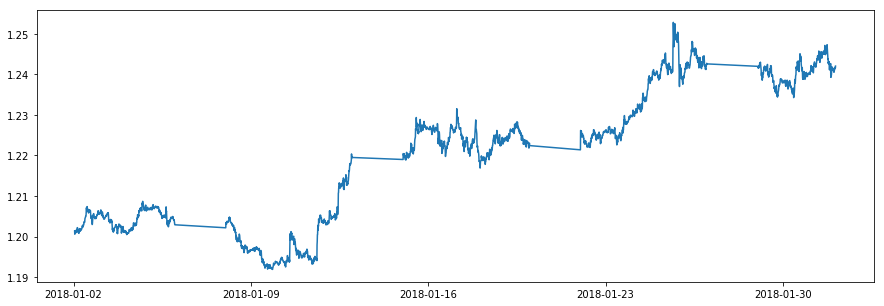

In [156]:
plt.figure(figsize=(15,5))
plt.plot(X.index,X.iloc[:,5]);

In [157]:
data_set.index[2], data_set.index[-1]

(Timestamp('2018-01-02 00:20:00'), Timestamp('2018-02-01 02:00:00'))

In [158]:
X.index[0], X.index[-1]

(Timestamp('2018-01-02 01:00:00'), Timestamp('2018-02-01 01:50:00'))

In [159]:
bt.shape, X.shape

((3141,), (3141, 9))

In [160]:
X.head()

,0,1,2,3,4,5,6,PNL_0,PNL_1
2018-01-02 01:00:00,1.20015,1.20082,1.20049,1.20079,1.20143,1.20133,1.20058,-0.00038,0.00019
2018-01-02 01:10:00,1.20082,1.20049,1.20079,1.20143,1.20133,1.20058,1.20087,-0.00053,0.00038
2018-01-02 01:20:00,1.20049,1.20079,1.20143,1.20133,1.20058,1.20087,1.20134,-0.00016,0.00004
2018-01-02 01:30:00,1.20079,1.20143,1.20133,1.20058,1.20087,1.20134,1.20144,0.00031,-0.00041
2018-01-02 01:40:00,1.20143,1.20133,1.20058,1.20087,1.20134,1.20144,1.20109,0.00006,-0.00015


In [19]:
print('tamaño de los datos= ',X.shape)
print()
print('# veces que baja lo suficiente para ganar = ',sum(bt==0),' | ', np.mean(bt==0),'%')
print('# veces que baja pero pierdo = ',sum(bt==2),' | ', np.mean(bt==2),'%')
print('--------------------------------------------')
print('# veces que sube lo suficiente para ganar = ',sum(bt==1),' | ', np.mean(bt==1),'%')
print('# veces que sube pero pierdo = ',sum(bt==3),' | ', np.mean(bt==3),'%')
print('--------------------------------------------')
print('probabilidad de ganar = ', (np.mean(bt==0)+np.mean(bt==1))*100)
print('probabilidad de perder = ', (np.mean(bt==2)+np.mean(bt==3))*100)

tamaño de los datos=  (84509, 9)

# veces que baja lo suficiente para ganar =  24810  |  0.293578198772 %
# veces que baja pero pierdo =  17679  |  0.209196653611 %
--------------------------------------------
# veces que sube lo suficiente para ganar =  25097  |  0.296974286762 %
# veces que sube pero pierdo =  16923  |  0.200250860855 %
--------------------------------------------
probabilidad de ganar =  59.0552485534
probabilidad de perder =  40.9447514466


In [164]:
sum(X.PNL_0>0), sum(X.PNL_1>0)

(1410, 1444)

In [15]:
%run ../code/redim.py
%run ../code/step_validation.py
%run ../code/v_split.py

In [20]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_0','PNL_1'])
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB 20s ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('longest_buy: ', np.max(result_GNB[:,3]))
print('longest_sell: ', np.max(result_GNB[:,4]))
print('%correct_1: ', np.mean(result_GNB[:,5]))
print('%correct_0: ', np.mean(result_GNB[:,6]))
print('%correct_3: ', np.mean(result_GNB[:,7]))
print('%correct_2: ', np.mean(result_GNB[:,8]))
print('% correct total: ', np.mean(result_GNB[:,5]+result_GNB[:,6]+result_GNB[:,7]+result_GNB[:,8]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_20s_GNB_NC4_wsize7_2018-01.csv')

--------- GaussianNB 20s ----------------
average PNL :  -0.117301052632
average buy:  1223.73684211
average sell:  2464.26315789
longest_buy:  3676.0
longest_sell:  4028.0
%correct_1:  0.0685062467915
%correct_0:  0.168221345043
%correct_3:  0.0147867481814
%correct_2:  0.0349988763011
% correct total:  0.286513216317
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.04362  3392.0   214.0         361.0         2764.0    0.024404   
2018-01-09 -0.12502  3676.0     0.0        3676.0            0.0    0.260609   
2018-01-10 -0.10978  3802.0     0.0        1935.0          669.0    0.215939   
2018-01-11 -0.08908  3707.0    93.0        2279.0         1521.0    0.164474   
2018-01-12 -0.16796     0.0  3841.0           0.0         3841.0    0.000000   
2018-01-15 -0.17345   189.0  3653.0          73.0         1998.0    0.014315   
2018-01-16 -0.14143     0.0  3877.0           0.0         3877.0    0.000000   
2

In [21]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_0','PNL_1'])
result_KNC = step_validation(est_KNC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('--------- KNeighbors 20s ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('longest_buy: ', np.max(result_KNC[:,3]))
print('longest_sell: ', np.max(result_KNC[:,4]))
print('%correct_1: ', np.mean(result_KNC[:,5]))
print('%correct_0: ', np.mean(result_KNC[:,6]))
print('%correct_3: ', np.mean(result_KNC[:,7]))
print('%correct_2: ', np.mean(result_KNC[:,8]))
print('% correct total: ', np.mean(result_KNC[:,5]+result_KNC[:,6]+result_KNC[:,7]+result_KNC[:,8]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_20s_KNC_NC4_wsize7_2018-01.csv')

--------- KNeighbors 20s ----------------
average PNL :  -0.106343157895
average buy:  1430.73684211
average sell:  2257.26315789
longest_buy:  2262.0
longest_sell:  3434.0
%correct_1:  0.0822882284799
%correct_0:  0.154590794684
%correct_3:  0.0290802722663
%correct_2:  0.0290681667055
% correct total:  0.295027462136
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.04105  2668.0   938.0          15.0         1674.0    0.025790   
2018-01-09 -0.08997  2955.0   721.0        2262.0           78.0    0.205930   
2018-01-10 -0.08842  1504.0  2298.0          34.0           62.0    0.079958   
2018-01-11 -0.06663  1498.0  2302.0           9.0           53.0    0.068947   
2018-01-12 -0.13720   466.0  3375.0          12.0         2341.0    0.022911   
2018-01-15 -0.14817   352.0  3490.0          18.0         2278.0    0.012754   
2018-01-16 -0.10388  1503.0  2374.0          33.0           53.0    0.086923   
2

In [22]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column=['PNL_0','PNL_1'])
result_DTC = step_validation(est_DTC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('--------- DecisionTree 20s ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('longest_buy: ', np.max(result_DTC[:,3]))
print('longest_sell: ', np.max(result_DTC[:,4]))
print('%correct_1: ', np.mean(result_DTC[:,5]))
print('%correct_0: ', np.mean(result_DTC[:,6]))
print('%correct_3: ', np.mean(result_DTC[:,7]))
print('%correct_2: ', np.mean(result_DTC[:,8]))
print('% correct total: ', np.mean(result_DTC[:,5]+result_DTC[:,6]+result_DTC[:,7]+result_DTC[:,8]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_20s_DTC_NC4_wsize7_2018-01.csv')

--------- DecisionTree 20s ----------------
average PNL :  -0.0941652631579
average buy:  1973.05263158
average sell:  1714.94736842
longest_buy:  3122.0
longest_sell:  2276.0
%correct_1:  0.122201671436
%correct_0:  0.0866769694055
%correct_3:  0.0318313703106
%correct_2:  0.0409229350994
% correct total:  0.281632946252
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.03440   778.0  2828.0           7.0         1679.0    0.022463   
2018-01-09 -0.09455  3026.0   650.0        2263.0           49.0    0.211643   
2018-01-10 -0.08160  1760.0  2042.0          18.0           53.0    0.087849   
2018-01-11 -0.06661  1824.0  1976.0           7.0           44.0    0.085526   
2018-01-12 -0.10934  3206.0   635.0        2327.0           36.0    0.269461   
2018-01-15 -0.14629   418.0  3424.0          15.0         2276.0    0.016918   
2018-01-16 -0.09101  1810.0  2067.0          27.0           51.0    0.093371  

In [23]:
from  sklearn.ensemble  import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column=['PNL_1','PNL_0'])
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('--------- RandomForest 20s ----------------')
print('average PNL : ', np.mean(result_RFC[:,0]))
print('average buy: ', np.mean(result_RFC[:,1]))
print('average sell: ', np.mean(result_RFC[:,2]))
print('longest_buy: ', np.max(result_RFC[:,3]))
print('longest_sell: ', np.max(result_RFC[:,4]))
print('%correct_1: ', np.mean(result_RFC[:,5]))
print('%correct_0: ', np.mean(result_RFC[:,6]))
print('%correct_3: ', np.mean(result_RFC[:,7]))
print('%correct_2: ', np.mean(result_RFC[:,8]))
print('% correct total: ', np.mean(result_RFC[:,5]+result_RFC[:,6]+result_RFC[:,7]+result_RFC[:,8]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_20s_RFC_NC4_wsize7_2018-01.csv')

--------- RandomForest 20s ----------------
average PNL :  -0.109260526316
average buy:  1552.94736842
average sell:  2135.05263158
longest_buy:  2267.0
longest_sell:  2509.0
%correct_1:  0.0909216596326
%correct_0:  0.147484711869
%correct_3:  0.0294895085251
%correct_2:  0.0250417788067
% correct total:  0.292937658833
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.04061  2914.0   692.0          10.0         1687.0    0.032723   
2018-01-09 -0.09472  3060.0   616.0        2267.0           78.0    0.211915   
2018-01-10 -0.08877  1616.0  2186.0          37.0           76.0    0.090742   
2018-01-11 -0.07963  1655.0  2145.0           7.0           45.0    0.089211   
2018-01-12 -0.13672   492.0  3349.0          10.0         2343.0    0.023431   
2018-01-15 -0.14365   440.0  3402.0          10.0         2278.0    0.014315   
2018-01-16 -0.10354  1699.0  2178.0          28.0           49.0    0.093629   

### Ahora con 30s

In [27]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_30s_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)
X, y_reg, bt = build_dataset(data_set,window=7,binary_target=True,PNL=True)
X.shape

(58022, 9)

In [28]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_0','PNL_1'])
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB 30s ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('longest_buy: ', np.max(result_GNB[:,3]))
print('longest_sell: ', np.max(result_GNB[:,4]))
print('%correct_1: ', np.mean(result_GNB[:,5]))
print('%correct_0: ', np.mean(result_GNB[:,6]))
print('%correct_3: ', np.mean(result_GNB[:,7]))
print('%correct_2: ', np.mean(result_GNB[:,8]))
print('% correct total: ', np.mean(result_GNB[:,5]+result_GNB[:,6]+result_GNB[:,7]+result_GNB[:,8]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_30s_GNB_NC4_wsize7_2018-01.csv')

--------- GaussianNB 30s ----------------
average PNL :  -0.0798657894737
average buy:  955.421052632
average sell:  1569.63157895
longest_buy:  2642.0
longest_sell:  2744.0
%correct_1:  0.0892588478996
%correct_0:  0.17706820806
%correct_3:  0.0257127939041
%correct_2:  0.0141542690702
% correct total:  0.306194118933
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.03426  2416.0   108.0         295.0         1798.0    0.042789   
2018-01-09 -0.09265  2460.0    66.0        1632.0           18.0    0.289786   
2018-01-10 -0.08007  2413.0   204.0        1356.0          211.0    0.262896   
2018-01-11 -0.06122  2501.0   106.0        1553.0         1054.0    0.172612   
2018-01-12 -0.08272   975.0  1651.0           0.0         2626.0    0.000000   
2018-01-15 -0.10342  2642.0     0.0        2642.0            0.0    0.321347   
2018-01-16 -0.09765     0.0  2644.0           0.0         2644.0    0.000000   
2

In [29]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_0','PNL_1'])
result_KNC = step_validation(est_KNC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('--------- KNeighbors 30s ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('longest_buy: ', np.max(result_KNC[:,3]))
print('longest_sell: ', np.max(result_KNC[:,4]))
print('%correct_1: ', np.mean(result_KNC[:,5]))
print('%correct_0: ', np.mean(result_KNC[:,6]))
print('%correct_3: ', np.mean(result_KNC[:,7]))
print('%correct_2: ', np.mean(result_KNC[:,8]))
print('% correct total: ', np.mean(result_KNC[:,5]+result_KNC[:,6]+result_KNC[:,7]+result_KNC[:,8]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_30s_KNC_NC4_wsize7_2018-01.csv')

--------- KNeighbors 30s ----------------
average PNL :  -0.0810884210526
average buy:  978.315789474
average sell:  1546.73684211
longest_buy:  1551.0
longest_sell:  2337.0
%correct_1:  0.0960892912441
%correct_0:  0.179383730369
%correct_3:  0.0204568296365
%correct_2:  0.0182870466063
% correct total:  0.314216897856
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.03149  1998.0   526.0          13.0         1181.0    0.029715   
2018-01-09 -0.06879  1956.0   570.0        1551.0           38.0    0.248219   
2018-01-10 -0.06966   923.0  1694.0          16.0           90.0    0.085212   
2018-01-11 -0.05867  1023.0  1584.0           6.0           82.0    0.076333   
2018-01-12 -0.10562   284.0  2342.0          12.0         1687.0    0.019802   
2018-01-15 -0.10401   231.0  2411.0          30.0         1560.0    0.020439   
2018-01-16 -0.07538  1110.0  1534.0          13.0           31.0    0.107035   


In [30]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column=['PNL_0','PNL_1'])
result_DTC = step_validation(est_DTC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('--------- DecisionTree 30s ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('longest_buy: ', np.max(result_DTC[:,3]))
print('longest_sell: ', np.max(result_DTC[:,4]))
print('%correct_1: ', np.mean(result_DTC[:,5]))
print('%correct_0: ', np.mean(result_DTC[:,6]))
print('%correct_3: ', np.mean(result_DTC[:,7]))
print('%correct_2: ', np.mean(result_DTC[:,8]))
print('% correct total: ', np.mean(result_DTC[:,5]+result_DTC[:,6]+result_DTC[:,7]+result_DTC[:,8]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_30s_DTC_NC4_wsize7_2018-01.csv')

--------- DecisionTree 30s ----------------
average PNL :  -0.0618205263158
average buy:  1220.15789474
average sell:  1304.89473684
longest_buy:  1551.0
longest_sell:  2331.0
%correct_1:  0.097005037536
%correct_0:  0.118933379402
%correct_3:  0.0319323423038
%correct_2:  0.0322866514316
% correct total:  0.280157410674
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02816   537.0  1987.0           7.0         1174.0    0.034073   
2018-01-09 -0.06795  2035.0   491.0        1551.0           45.0    0.245051   
2018-01-10 -0.05691  1252.0  1365.0          12.0           51.0    0.098586   
2018-01-11 -0.05214  1245.0  1362.0           8.0           23.0    0.096279   
2018-01-12 -0.02431  2113.0   513.0           9.0         1572.0    0.018660   
2018-01-15 -0.01900  1983.0   659.0           7.0         1557.0    0.015519   
2018-01-16 -0.07816  1398.0  1246.0          32.0           36.0    0.123676   

In [31]:
from  sklearn.ensemble  import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column=['PNL_1','PNL_0'])
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('--------- RandomForest 30s ----------------')
print('average PNL : ', np.mean(result_RFC[:,0]))
print('average buy: ', np.mean(result_RFC[:,1]))
print('average sell: ', np.mean(result_RFC[:,2]))
print('longest_buy: ', np.max(result_RFC[:,3]))
print('longest_sell: ', np.max(result_RFC[:,4]))
print('%correct_1: ', np.mean(result_RFC[:,5]))
print('%correct_0: ', np.mean(result_RFC[:,6]))
print('%correct_3: ', np.mean(result_RFC[:,7]))
print('%correct_2: ', np.mean(result_RFC[:,8]))
print('% correct total: ', np.mean(result_RFC[:,5]+result_RFC[:,6]+result_RFC[:,7]+result_RFC[:,8]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_30s_RFC_NC4_wsize7_2018-01.csv')

--------- RandomForest 30s ----------------
average PNL :  -0.0778710526316
average buy:  1045.15789474
average sell:  1479.89473684
longest_buy:  1566.0
longest_sell:  2337.0
%correct_1:  0.119572692655
%correct_0:  0.146782012416
%correct_3:  0.0121698719272
%correct_2:  0.0246055974875
% correct total:  0.303130174486
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.03145   508.0  2016.0           8.0         1181.0    0.032092   
2018-01-09 -0.06515  2017.0   509.0        1551.0           72.0    0.253761   
2018-01-10 -0.07007  1093.0  1524.0          17.0           70.0    0.104700   
2018-01-11 -0.06755  1142.0  1465.0           7.0           46.0    0.095896   
2018-01-12 -0.08112  2086.0   540.0        1566.0           26.0    0.288652   
2018-01-15 -0.09594   241.0  2401.0          33.0         1560.0    0.014762   
2018-01-16 -0.08886  1157.0  1487.0          31.0           42.0    0.116868   

### Ahora con 40s

In [32]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_40s_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)
X, y_reg, bt = build_dataset(data_set,window=7,binary_target=True,PNL=True)
X.shape

(44141, 9)

In [33]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_0','PNL_1'])
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB 40s ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('longest_buy: ', np.max(result_GNB[:,3]))
print('longest_sell: ', np.max(result_GNB[:,4]))
print('%correct_1: ', np.mean(result_GNB[:,5]))
print('%correct_0: ', np.mean(result_GNB[:,6]))
print('%correct_3: ', np.mean(result_GNB[:,7]))
print('%correct_2: ', np.mean(result_GNB[:,8]))
print('% correct total: ', np.mean(result_GNB[:,5]+result_GNB[:,6]+result_GNB[:,7]+result_GNB[:,8]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_40s_GNB_NC4_wsize7_2018-01.csv')

--------- GaussianNB 40s ----------------
average PNL :  -0.0602663157895
average buy:  858.736842105
average sell:  1060.21052632
longest_buy:  2017.0
longest_sell:  2076.0
%correct_1:  0.105416729655
%correct_0:  0.172820580069
%correct_3:  0.0306664398981
%correct_2:  0.00780058241952
% correct total:  0.316704332041
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.03125  1882.0    60.0         268.0         1279.0    0.063852   
2018-01-09 -0.06740  1933.0     0.0        1933.0            0.0    0.311433   
2018-01-10 -0.06446  1973.0     8.0        1048.0          114.0    0.322564   
2018-01-11 -0.04711  1918.0    83.0        1202.0          799.0    0.195902   
2018-01-12 -0.02571  1685.0   312.0           0.0         1997.0    0.000000   
2018-01-15 -0.07911  2017.0     0.0        2017.0            0.0    0.331681   
2018-01-16 -0.07435     0.0  2000.0           0.0         2000.0    0.000000   


In [35]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_0','PNL_1'])
result_KNC = step_validation(est_KNC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('--------- KNeighbors 40s ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('longest_buy: ', np.max(result_KNC[:,3]))
print('longest_sell: ', np.max(result_KNC[:,4]))
print('%correct_1: ', np.mean(result_KNC[:,5]))
print('%correct_0: ', np.mean(result_KNC[:,6]))
print('%correct_3: ', np.mean(result_KNC[:,7]))
print('%correct_2: ', np.mean(result_KNC[:,8]))
print('% correct total: ', np.mean(result_KNC[:,5]+result_KNC[:,6]+result_KNC[:,7]+result_KNC[:,8]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_40s_KNC_NC4_wsize7_2018-01.csv')

--------- KNeighbors 40s ----------------
average PNL :  -0.0656457894737
average buy:  788.947368421
average sell:  1130.0
longest_buy:  1186.0
longest_sell:  1769.0
%correct_1:  0.108244194773
%correct_0:  0.184157917666
%correct_3:  0.0195758125587
%correct_2:  0.0131206820607
% correct total:  0.325098607058
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02963  1487.0   455.0          10.0          892.0    0.032956   
2018-01-09 -0.05113  1585.0   348.0        1186.0           31.0    0.251940   
2018-01-10 -0.06972   712.0  1269.0          22.0          117.0    0.097930   
2018-01-11 -0.05108   757.0  1244.0           9.0           27.0    0.105947   
2018-01-12 -0.08319   198.0  1799.0           6.0         1275.0    0.023535   
2018-01-15 -0.06246   809.0  1208.0          39.0         1183.0    0.033218   
2018-01-16 -0.05423   856.0  1144.0          28.0           21.0    0.137000   
2018-01-

In [36]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column=['PNL_0','PNL_1'])
result_DTC = step_validation(est_DTC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('--------- DecisionTree 40s ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('longest_buy: ', np.max(result_DTC[:,3]))
print('longest_sell: ', np.max(result_DTC[:,4]))
print('%correct_1: ', np.mean(result_DTC[:,5]))
print('%correct_0: ', np.mean(result_DTC[:,6]))
print('%correct_3: ', np.mean(result_DTC[:,7]))
print('%correct_2: ', np.mean(result_DTC[:,8]))
print('% correct total: ', np.mean(result_DTC[:,5]+result_DTC[:,6]+result_DTC[:,7]+result_DTC[:,8]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_40s_DTC_NC4_wsize7_2018-01.csv')

--------- DecisionTree 40s ----------------
average PNL :  -0.0509136842105
average buy:  1009.47368421
average sell:  909.473684211
longest_buy:  1191.0
longest_sell:  1769.0
%correct_1:  0.108881090517
%correct_0:  0.130620802094
%correct_3:  0.0377551601001
%correct_2:  0.0169138101783
% correct total:  0.294170862889
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02341  1570.0   372.0           8.0          899.0    0.031411   
2018-01-09 -0.05355  1608.0   325.0        1191.0           31.0    0.252457   
2018-01-10 -0.04447   975.0  1006.0          22.0           72.0    0.125189   
2018-01-11 -0.04443   989.0  1012.0           7.0           27.0    0.114943   
2018-01-12 -0.02158  1661.0   336.0           8.0         1187.0    0.034552   
2018-01-15 -0.01327  1791.0   226.0          13.0         1186.0    0.026277   
2018-01-16 -0.05019   909.0  1091.0          12.0           27.0    0.128000   

In [37]:
from  sklearn.ensemble  import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column=['PNL_1','PNL_0'])
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('--------- RandomForest 40s ----------------')
print('average PNL : ', np.mean(result_RFC[:,0]))
print('average buy: ', np.mean(result_RFC[:,1]))
print('average sell: ', np.mean(result_RFC[:,2]))
print('longest_buy: ', np.max(result_RFC[:,3]))
print('longest_sell: ', np.max(result_RFC[:,4]))
print('%correct_1: ', np.mean(result_RFC[:,5]))
print('%correct_0: ', np.mean(result_RFC[:,6]))
print('%correct_3: ', np.mean(result_RFC[:,7]))
print('%correct_2: ', np.mean(result_RFC[:,8]))
print('% correct total: ', np.mean(result_RFC[:,5]+result_RFC[:,6]+result_RFC[:,7]+result_RFC[:,8]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_40s_RFC_NC4_wsize7_2018-01.csv')

--------- RandomForest 40s ----------------
average PNL :  -0.0619342105263
average buy:  936.210526316
average sell:  982.736842105
longest_buy:  1191.0
longest_sell:  1768.0
%correct_1:  0.129887914672
%correct_0:  0.160737568515
%correct_3:  0.0208942007936
%correct_2:  0.0111441827431
% correct total:  0.322663866724
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02737  1514.0   428.0          11.0          891.0    0.041710   
2018-01-09 -0.05601  1521.0   412.0        1191.0           40.0    0.247801   
2018-01-10 -0.05886   824.0  1157.0          24.0           78.0    0.118627   
2018-01-11 -0.04614   887.0  1114.0          12.0           18.0    0.128936   
2018-01-12 -0.05976  1540.0   457.0        1175.0           61.0    0.305458   
2018-01-15 -0.02443  1624.0   393.0          36.0         1184.0    0.029251   
2018-01-16 -0.07310   843.0  1157.0          17.0           44.0    0.124000   

### ahora con 50s

In [38]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_50s_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)
X, y_reg, bt = build_dataset(data_set,window=7,binary_target=True,PNL=True)
X.shape

(35782, 9)

In [39]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_0','PNL_1'])
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB 50s ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('longest_buy: ', np.max(result_GNB[:,3]))
print('longest_sell: ', np.max(result_GNB[:,4]))
print('%correct_1: ', np.mean(result_GNB[:,5]))
print('%correct_0: ', np.mean(result_GNB[:,6]))
print('%correct_3: ', np.mean(result_GNB[:,7]))
print('%correct_2: ', np.mean(result_GNB[:,8]))
print('% correct total: ', np.mean(result_GNB[:,5]+result_GNB[:,6]+result_GNB[:,7]+result_GNB[:,8]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_50s_GNB_NC4_wsize7_2018-01.csv')

--------- GaussianNB 50s ----------------
average PNL :  -0.0512621052632
average buy:  589.578947368
average sell:  963.315789474
longest_buy:  1630.0
longest_sell:  1662.0
%correct_1:  0.106079572881
%correct_0:  0.203916271641
%correct_3:  0.0166674450537
%correct_2:  0.0075253600046
% correct total:  0.33418864958
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02644  1496.0    77.0         221.0         1020.0    0.064844   
2018-01-09 -0.05642   685.0   908.0         677.0          846.0    0.111739   
2018-01-10 -0.05417  1500.0   113.0         859.0           94.0    0.325480   
2018-01-11 -0.04612  1437.0   177.0         976.0          638.0    0.201983   
2018-01-12 -0.07762   282.0  1330.0         248.0         1151.0    0.069479   
2018-01-15 -0.06128  1630.0     0.0        1630.0            0.0    0.351534   
2018-01-16 -0.05921     0.0  1606.0           0.0         1606.0    0.000000   
20

In [40]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_0','PNL_1'])
result_KNC = step_validation(est_KNC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('--------- KNeighbors 50s ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('longest_buy: ', np.max(result_KNC[:,3]))
print('longest_sell: ', np.max(result_KNC[:,4]))
print('%correct_1: ', np.mean(result_KNC[:,5]))
print('%correct_0: ', np.mean(result_KNC[:,6]))
print('%correct_3: ', np.mean(result_KNC[:,7]))
print('%correct_2: ', np.mean(result_KNC[:,8]))
print('% correct total: ', np.mean(result_KNC[:,5]+result_KNC[:,6]+result_KNC[:,7]+result_KNC[:,8]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_50s_KNC_NC4_wsize7_2018-01.csv')

--------- KNeighbors 50s ----------------
average PNL :  -0.0548442105263
average buy:  616.263157895
average sell:  936.631578947
longest_buy:  958.0
longest_sell:  1455.0
%correct_1:  0.118086560128
%correct_0:  0.203610781743
%correct_3:  0.0114283722704
%correct_2:  0.00931536810264
% correct total:  0.342441082244
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02762  1218.0   355.0          18.0          712.0    0.038779   
2018-01-09 -0.04447  1267.0   326.0         958.0           55.0    0.257376   
2018-01-10 -0.05732   505.0  1108.0           8.0          153.0    0.092374   
2018-01-11 -0.04929   622.0   992.0           6.0           23.0    0.107807   
2018-01-12 -0.07019   189.0  1423.0          14.0         1025.0    0.032258   
2018-01-15 -0.07223   190.0  1440.0          26.0          959.0    0.034356   
2018-01-16 -0.06064   789.0   817.0          48.0           24.0    0.155666   
2

In [41]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column=['PNL_0','PNL_1'])
result_DTC = step_validation(est_DTC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('--------- DecisionTree 50s ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('longest_buy: ', np.max(result_DTC[:,3]))
print('longest_sell: ', np.max(result_DTC[:,4]))
print('%correct_1: ', np.mean(result_DTC[:,5]))
print('%correct_0: ', np.mean(result_DTC[:,6]))
print('%correct_3: ', np.mean(result_DTC[:,7]))
print('%correct_2: ', np.mean(result_DTC[:,8]))
print('% correct total: ', np.mean(result_DTC[:,5]+result_DTC[:,6]+result_DTC[:,7]+result_DTC[:,8]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_50s_DTC_NC4_wsize7_2018-01.csv')

--------- DecisionTree 50s ----------------
average PNL :  -0.0420731578947
average buy:  696.105263158
average sell:  856.789473684
longest_buy:  32.0
longest_sell:  1433.0
%correct_1:  0.103842437098
%correct_0:  0.12968531469
%correct_3:  0.0221737269261
%correct_2:  0.0244503320023
% correct total:  0.280151810717
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02009  1239.0   334.0           6.0          714.0    0.034965   
2018-01-09 -0.04104   353.0  1240.0           6.0          957.0    0.035154   
2018-01-10 -0.03733   662.0   951.0          18.0           51.0    0.127092   
2018-01-11 -0.02707   783.0   831.0           7.0           26.0    0.114622   
2018-01-12 -0.06677   236.0  1376.0          13.0         1022.0    0.035980   
2018-01-15 -0.01643   149.0  1481.0          28.0          964.0    0.026994   
2018-01-16 -0.05396   910.0   696.0          32.0           23.0    0.151308   
20

In [42]:
from  sklearn.ensemble  import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column=['PNL_1','PNL_0'])
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('--------- RandomForest 50s ----------------')
print('average PNL : ', np.mean(result_RFC[:,0]))
print('average buy: ', np.mean(result_RFC[:,1]))
print('average sell: ', np.mean(result_RFC[:,2]))
print('longest_buy: ', np.max(result_RFC[:,3]))
print('longest_sell: ', np.max(result_RFC[:,4]))
print('%correct_1: ', np.mean(result_RFC[:,5]))
print('%correct_0: ', np.mean(result_RFC[:,6]))
print('%correct_3: ', np.mean(result_RFC[:,7]))
print('%correct_2: ', np.mean(result_RFC[:,8]))
print('% correct total: ', np.mean(result_RFC[:,5]+result_RFC[:,6]+result_RFC[:,7]+result_RFC[:,8]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_50s_RFC_NC4_wsize7_2018-01.csv')

--------- RandomForest 50s ----------------
average PNL :  -0.0506989473684
average buy:  696.684210526
average sell:  856.210526316
longest_buy:  958.0
longest_sell:  1444.0
%correct_1:  0.126251619289
%correct_0:  0.163096789549
%correct_3:  0.0122895571592
%correct_2:  0.0139453680377
% correct total:  0.315583334035
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02566  1261.0   312.0          12.0          712.0    0.049587   
2018-01-09 -0.04696  1266.0   327.0         958.0           38.0    0.257376   
2018-01-10 -0.04992   647.0   966.0          19.0           65.0    0.129572   
2018-01-11 -0.04356   684.0   930.0           7.0           20.0    0.117720   
2018-01-12 -0.06778   190.0  1422.0           9.0         1025.0    0.034119   
2018-01-15 -0.06741   155.0  1475.0          28.0          957.0    0.028221   
2018-01-16 -0.06784   829.0   777.0          32.0           24.0    0.160648   


### ahora con 1 minuto

In [44]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_1T_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)
X, y_reg, bt = build_dataset(data_set,window=7,binary_target=True,PNL=True)
X.shape

(30030, 9)

In [45]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_0','PNL_1'])
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB 1m ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('longest_buy: ', np.max(result_GNB[:,3]))
print('longest_sell: ', np.max(result_GNB[:,4]))
print('%correct_1: ', np.mean(result_GNB[:,5]))
print('%correct_0: ', np.mean(result_GNB[:,6]))
print('%correct_3: ', np.mean(result_GNB[:,7]))
print('%correct_2: ', np.mean(result_GNB[:,8]))
print('% correct total: ', np.mean(result_GNB[:,5]+result_GNB[:,6]+result_GNB[:,7]+result_GNB[:,8]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_1T_GNB_NC4_wsize7_2018-01.csv')

--------- GaussianNB 1m ----------------
average PNL :  -0.0438
average buy:  610.0
average sell:  692.263157895
longest_buy:  1375.0
longest_sell:  1393.0
%correct_1:  0.131129400647
%correct_0:  0.189120689908
%correct_3:  0.0155480103106
%correct_2:  0.00260521157259
% correct total:  0.338403312438
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02230  1262.0    66.0         184.0          869.0    0.069277   
2018-01-09 -0.04724  1323.0     0.0        1323.0            0.0    0.337113   
2018-01-10 -0.04458  1266.0   103.0         731.0           80.0    0.343316   
2018-01-11 -0.04624   830.0   543.0         830.0          543.0    0.217043   
2018-01-12 -0.05272   393.0   964.0           0.0         1357.0    0.000000   
2018-01-15 -0.05154  1375.0     0.0        1375.0            0.0    0.367273   
2018-01-16 -0.05129     0.0  1357.0           0.0         1357.0    0.000000   
2018-01-17 -0.0482

In [46]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_0','PNL_1'])
result_KNC = step_validation(est_KNC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('--------- KNeighbors 1m ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('longest_buy: ', np.max(result_KNC[:,3]))
print('longest_sell: ', np.max(result_KNC[:,4]))
print('%correct_1: ', np.mean(result_KNC[:,5]))
print('%correct_0: ', np.mean(result_KNC[:,6]))
print('%correct_3: ', np.mean(result_KNC[:,7]))
print('%correct_2: ', np.mean(result_KNC[:,8]))
print('% correct total: ', np.mean(result_KNC[:,5]+result_KNC[:,6]+result_KNC[:,7]+result_KNC[:,8]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_1T_KNC_NC4_wsize7_2018-01.csv')

--------- KNeighbors 1m ----------------
average PNL :  -0.0485605263158
average buy:  521.894736842
average sell:  780.368421053
longest_buy:  796.0
longest_sell:  1202.0
%correct_1:  0.122686423218
%correct_0:  0.204743209872
%correct_3:  0.0104958800859
%correct_2:  0.00612408293379
% correct total:  0.34404959611
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02132  1039.0   289.0          18.0          618.0    0.051205   
2018-01-09 -0.03810  1042.0   281.0         796.0           49.0    0.265306   
2018-01-10 -0.04495   443.0   926.0           8.0           55.0    0.109569   
2018-01-11 -0.03105   521.0   852.0           7.0           30.0    0.120175   
2018-01-12 -0.06839   154.0  1203.0           9.0          849.0    0.028740   
2018-01-15 -0.06002    92.0  1283.0          23.0         1041.0    0.026182   
2018-01-16 -0.05721   668.0   689.0          30.0           15.0    0.151805   
201

In [47]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column=['PNL_0','PNL_1'])
result_DTC = step_validation(est_DTC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('--------- DecisionTree 1m ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('longest_buy: ', np.max(result_DTC[:,3]))
print('longest_sell: ', np.max(result_DTC[:,4]))
print('%correct_1: ', np.mean(result_DTC[:,5]))
print('%correct_0: ', np.mean(result_DTC[:,6]))
print('%correct_3: ', np.mean(result_DTC[:,7]))
print('%correct_2: ', np.mean(result_DTC[:,8]))
print('% correct total: ', np.mean(result_DTC[:,5]+result_DTC[:,6]+result_DTC[:,7]+result_DTC[:,8]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_1T_DTC_NC4_wsize7_2018-01.csv')

--------- DecisionTree 1m ----------------
average PNL :  -0.0408084210526
average buy:  679.210526316
average sell:  623.052631579
longest_buy:  802.0
longest_sell:  1201.0
%correct_1:  0.149509239756
%correct_0:  0.143493117252
%correct_3:  0.0160800402866
%correct_2:  0.0120736535644
% correct total:  0.321156050859
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02085  1072.0   256.0           9.0          606.0    0.036145   
2018-01-09 -0.03782  1056.0   267.0         792.0           22.0    0.272109   
2018-01-10 -0.03971   553.0   816.0          14.0           52.0    0.114682   
2018-01-11 -0.03382   709.0   664.0           9.0           17.0    0.132556   
2018-01-12 -0.03869  1105.0   252.0         793.0           33.0    0.324982   
2018-01-15 -0.04793  1055.0   320.0         802.0           60.0    0.281455   
2018-01-16 -0.04466   687.0   670.0          19.0           32.0    0.149595   
2

In [48]:
from  sklearn.ensemble  import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column=['PNL_1','PNL_0'])
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('--------- RandomForest 1m ----------------')
print('average PNL : ', np.mean(result_RFC[:,0]))
print('average buy: ', np.mean(result_RFC[:,1]))
print('average sell: ', np.mean(result_RFC[:,2]))
print('longest_buy: ', np.max(result_RFC[:,3]))
print('longest_sell: ', np.max(result_RFC[:,4]))
print('%correct_1: ', np.mean(result_RFC[:,5]))
print('%correct_0: ', np.mean(result_RFC[:,6]))
print('%correct_3: ', np.mean(result_RFC[:,7]))
print('%correct_2: ', np.mean(result_RFC[:,8]))
print('% correct total: ', np.mean(result_RFC[:,5]+result_RFC[:,6]+result_RFC[:,7]+result_RFC[:,8]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_1T_RFC_NC4_wsize7_2018-01.csv')

--------- RandomForest 1m ----------------
average PNL :  -0.0412063157895
average buy:  645.947368421
average sell:  656.315789474
longest_buy:  792.0
longest_sell:  1205.0
%correct_1:  0.146389824493
%correct_0:  0.160274649118
%correct_3:  0.0144392526428
%correct_2:  0.00743997639284
% correct total:  0.328543702647
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.02494  1064.0   264.0          13.0          616.0    0.046687   
2018-01-09 -0.04005  1064.0   259.0         792.0           32.0    0.271353   
2018-01-10 -0.04341   566.0   803.0          31.0           57.0    0.144631   
2018-01-11 -0.03459   626.0   747.0           9.0           22.0    0.137655   
2018-01-12 -0.04149  1075.0   282.0         787.0           38.0    0.314665   
2018-01-15 -0.02007  1027.0   348.0          25.0          813.0    0.024727   
2018-01-16 -0.03754   683.0   674.0          23.0           23.0    0.173176   


### Ahora con los de 1T30s

In [49]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_1T30s_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)
X, y_reg, bt = build_dataset(data_set,window=7,binary_target=True,PNL=True)
X.shape

(20308, 9)

In [50]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_0','PNL_1'])
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB 1m30s ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('longest_buy: ', np.max(result_GNB[:,3]))
print('longest_sell: ', np.max(result_GNB[:,4]))
print('%correct_1: ', np.mean(result_GNB[:,5]))
print('%correct_0: ', np.mean(result_GNB[:,6]))
print('%correct_3: ', np.mean(result_GNB[:,7]))
print('%correct_2: ', np.mean(result_GNB[:,8]))
print('% correct total: ', np.mean(result_GNB[:,5]+result_GNB[:,6]+result_GNB[:,7]+result_GNB[:,8]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_1T30s_GNB_NC4_wsize7_2018-01.csv')

--------- GaussianNB 1m30s ----------------
average PNL :  -0.0293905263158
average buy:  470.421052632
average sell:  409.263157895
longest_buy:  924.0
longest_sell:  938.0
%correct_1:  0.172387810637
%correct_0:  0.182677730089
%correct_3:  0.0082161409447
%correct_2:  0.00140575798471
% correct total:  0.364687439655
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.01507  866.0   33.0         175.0          566.0    0.103448   
2018-01-09 -0.03412  910.0    0.0         910.0            0.0    0.358242   
2018-01-10 -0.02569  783.0  138.0         494.0          123.0    0.301846   
2018-01-11 -0.03234  546.0  364.0         349.0          359.0    0.218681   
2018-01-12 -0.04940  332.0  582.0         171.0          433.0    0.172867   
2018-01-15 -0.03105  910.0    0.0         910.0            0.0    0.406593   
2018-01-16 -0.03597  924.0    0.0         924.0            0.0    0.411255   
2018-01-17 -0.03

In [51]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_0','PNL_1'])
result_KNC = step_validation(est_KNC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('--------- KNeighbors 1m30s ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('longest_buy: ', np.max(result_KNC[:,3]))
print('longest_sell: ', np.max(result_KNC[:,4]))
print('%correct_1: ', np.mean(result_KNC[:,5]))
print('%correct_0: ', np.mean(result_KNC[:,6]))
print('%correct_3: ', np.mean(result_KNC[:,7]))
print('%correct_2: ', np.mean(result_KNC[:,8]))
print('% correct total: ', np.mean(result_KNC[:,5]+result_KNC[:,6]+result_KNC[:,7]+result_KNC[:,8]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_1T30s_KNC_NC4_wsize7_2018-01.csv')

--------- KNeighbors 1m30s ----------------
average PNL :  -0.0345015789474
average buy:  348.789473684
average sell:  530.894736842
longest_buy:  542.0
longest_sell:  807.0
%correct_1:  0.131333604117
%correct_0:  0.223349913523
%correct_3:  0.00675698071566
%correct_2:  0.00451066502757
% correct total:  0.365951163383
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.01883  680.0  219.0          10.0          408.0    0.048943   
2018-01-09 -0.03096  688.0  222.0         542.0           61.0    0.279121   
2018-01-10 -0.03323  341.0  580.0          14.0           35.0    0.112921   
2018-01-11 -0.02461  308.0  602.0          10.0           31.0    0.117582   
2018-01-12 -0.04981  118.0  796.0          10.0          578.0    0.047046   
2018-01-15 -0.04164   56.0  854.0          20.0          721.0    0.024176   
2018-01-16 -0.04025  484.0  440.0          27.0           30.0    0.189394   
2018-01-17 -0.0

In [52]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column=['PNL_0','PNL_1'])
result_DTC = step_validation(est_DTC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('--------- DecisionTree 1m30s ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('longest_buy: ', np.max(result_DTC[:,3]))
print('longest_sell: ', np.max(result_DTC[:,4]))
print('%correct_1: ', np.mean(result_DTC[:,5]))
print('%correct_0: ', np.mean(result_DTC[:,6]))
print('%correct_3: ', np.mean(result_DTC[:,7]))
print('%correct_2: ', np.mean(result_DTC[:,8]))
print('% correct total: ', np.mean(result_DTC[:,5]+result_DTC[:,6]+result_DTC[:,7]+result_DTC[:,8]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_1T30s_DTC_NC4_wsize7_2018-01.csv')

--------- DecisionTree 1m30s ----------------
average PNL :  -0.0326015789474
average buy:  392.526315789
average sell:  487.157894737
longest_buy:  539.0
longest_sell:  807.0
%correct_1:  0.14280878998
%correct_0:  0.172879409165
%correct_3:  0.0114435128632
%correct_2:  0.0168929621987
% correct total:  0.344024674207
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.01334  197.0  702.0           5.0          411.0    0.044494   
2018-01-09 -0.02618  739.0  171.0         539.0           26.0    0.287912   
2018-01-10 -0.02233  435.0  486.0          16.0           46.0    0.129207   
2018-01-11 -0.02357  409.0  501.0           7.0           22.0    0.121978   
2018-01-12 -0.04637  146.0  768.0          10.0          570.0    0.050328   
2018-01-15 -0.04071   89.0  821.0          16.0          534.0    0.039560   
2018-01-16 -0.03151  495.0  429.0          24.0           28.0    0.192641   
2018-01-17 -0.04

In [53]:
from  sklearn.ensemble  import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column=['PNL_1','PNL_0'])
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('--------- RandomForest 1m30s ----------------')
print('average PNL : ', np.mean(result_RFC[:,0]))
print('average buy: ', np.mean(result_RFC[:,1]))
print('average sell: ', np.mean(result_RFC[:,2]))
print('longest_buy: ', np.max(result_RFC[:,3]))
print('longest_sell: ', np.max(result_RFC[:,4]))
print('%correct_1: ', np.mean(result_RFC[:,5]))
print('%correct_0: ', np.mean(result_RFC[:,6]))
print('%correct_3: ', np.mean(result_RFC[:,7]))
print('%correct_2: ', np.mean(result_RFC[:,8]))
print('% correct total: ', np.mean(result_RFC[:,5]+result_RFC[:,6]+result_RFC[:,7]+result_RFC[:,8]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_1T30s_RFC_NC4_wsize7_2018-01.csv')

--------- RandomForest 1m30s ----------------
average PNL :  -0.0327984210526
average buy:  363.578947368
average sell:  516.105263158
longest_buy:  536.0
longest_sell:  801.0
%correct_1:  0.141873765871
%correct_0:  0.219350947942
%correct_3:  0.00590957771901
%correct_2:  0.004165881818
% correct total:  0.371300173351
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-08 -0.01569  716.0  183.0           9.0          399.0    0.064516   
2018-01-09 -0.03180  698.0  212.0         536.0           44.0    0.278022   
2018-01-10 -0.02542  345.0  576.0          14.0           40.0    0.132465   
2018-01-11 -0.02634  345.0  565.0           6.0           28.0    0.135165   
2018-01-12 -0.04675  131.0  783.0          10.0          571.0    0.051422   
2018-01-15 -0.04056   70.0  840.0          17.0          535.0    0.030769   
2018-01-16 -0.03768  484.0  440.0          20.0           17.0    0.201299   
2018-01-17 -0.0

### Ahora con los datos de 5T

In [54]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_5T_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)
X, y_reg, bt = build_dataset(data_set,window=7,binary_target=True,PNL=True)
X.shape

(6232, 9)

In [55]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_0','PNL_1'])
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB 5m ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('longest_buy: ', np.max(result_GNB[:,3]))
print('longest_sell: ', np.max(result_GNB[:,4]))
print('%correct_1: ', np.mean(result_GNB[:,5]))
print('%correct_0: ', np.mean(result_GNB[:,6]))
print('%correct_3: ', np.mean(result_GNB[:,7]))
print('%correct_2: ', np.mean(result_GNB[:,8]))
print('% correct total: ', np.mean(result_GNB[:,5]+result_GNB[:,6]+result_GNB[:,7]+result_GNB[:,8]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_5T_GNB_NC4_wsize7_2018-01.csv')

--------- GaussianNB 5m ----------------
average PNL :  -0.00428043478261
average buy:  136.217391304
average sell:  85.9565217391
longest_buy:  286.0
longest_sell:  280.0
%correct_1:  0.221467538418
%correct_0:  0.108109288875
%correct_3:  0.00433463070069
%correct_2:  0.00448383914844
% correct total:  0.338395297143
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-06 -0.00057    1.0    0.0           1.0            0.0    0.000000   
2018-01-08 -0.00641  265.0   14.0          62.0          167.0    0.125448   
2018-01-09 -0.01243  283.0    0.0         283.0            0.0    0.424028   
2018-01-10 -0.00442  225.0   56.0         151.0           47.0    0.309609   
2018-01-11 -0.00396  149.0  133.0         106.0          107.0    0.219858   
2018-01-12 -0.00427    8.0  272.0           0.0          280.0    0.000000   
2018-01-13 -0.00138    1.0    0.0           1.0            0.0    0.000000   
2018-01-15 -0.005

In [56]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_0','PNL_1'])
result_KNC = step_validation(est_KNC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('--------- KNeighbors 5m ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('longest_buy: ', np.max(result_KNC[:,3]))
print('longest_sell: ', np.max(result_KNC[:,4]))
print('%correct_1: ', np.mean(result_KNC[:,5]))
print('%correct_0: ', np.mean(result_KNC[:,6]))
print('%correct_3: ', np.mean(result_KNC[:,7]))
print('%correct_2: ', np.mean(result_KNC[:,8]))
print('% correct total: ', np.mean(result_KNC[:,5]+result_KNC[:,6]+result_KNC[:,7]+result_KNC[:,8]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_5T_KNC_NC4_wsize7_2018-01.csv')

--------- KNeighbors 5m ----------------
average PNL :  -0.00923565217391
average buy:  98.5652173913
average sell:  123.608695652
longest_buy:  150.0
longest_sell:  175.0
%correct_1:  0.193494715498
%correct_0:  0.178406986133
%correct_3:  0.00108364882554
%correct_2:  0.00496233646095
% correct total:  0.377947686918
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-06 -0.00057    1.0    0.0           1.0            0.0    0.000000   
2018-01-08 -0.01266  211.0   68.0         125.0            8.0    0.301075   
2018-01-09 -0.01348  155.0  128.0          20.0           18.0    0.226148   
2018-01-10 -0.01342  115.0  166.0          16.0           33.0    0.120996   
2018-01-11 -0.01618   70.0  212.0           6.0           55.0    0.099291   
2018-01-12 -0.00591  192.0   88.0         150.0           14.0    0.342857   
2018-01-13 -0.00138    1.0    0.0           1.0            0.0    0.000000   
2018-01-15 -0.000

In [57]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column=['PNL_0','PNL_1'])
result_DTC = step_validation(est_DTC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('--------- DecisionTree 5m ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('longest_buy: ', np.max(result_DTC[:,3]))
print('longest_sell: ', np.max(result_DTC[:,4]))
print('%correct_1: ', np.mean(result_DTC[:,5]))
print('%correct_0: ', np.mean(result_DTC[:,6]))
print('%correct_3: ', np.mean(result_DTC[:,7]))
print('%correct_2: ', np.mean(result_DTC[:,8]))
print('% correct total: ', np.mean(result_DTC[:,5]+result_DTC[:,6]+result_DTC[:,7]+result_DTC[:,8]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_5T_DTC_NC4_wsize7_2018-01.csv')

--------- DecisionTree 5m ----------------
average PNL :  -0.00840739130435
average buy:  105.434782609
average sell:  116.739130435
longest_buy:  171.0
longest_sell:  244.0
%correct_1:  0.178235270559
%correct_0:  0.15711484023
%correct_3:  0.0043281601778
%correct_2:  0.00294001274608
% correct total:  0.342618283713
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-06 -0.00121    0.0    1.0           0.0            1.0    0.000000   
2018-01-08 -0.00634   68.0  211.0          11.0          163.0    0.071685   
2018-01-09 -0.01210   93.0  190.0          23.0          164.0    0.116608   
2018-01-10 -0.00503  113.0  168.0          10.0           45.0    0.138790   
2018-01-11 -0.01392  111.0  171.0           9.0           14.0    0.131206   
2018-01-12  0.00103  213.0   67.0         171.0           27.0    0.382143   
2018-01-13 -0.00138    1.0    0.0           1.0            0.0    0.000000   
2018-01-15  0.002

In [58]:
from  sklearn.ensemble  import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column=['PNL_1','PNL_0'])
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('--------- RandomForest 5m ----------------')
print('average PNL : ', np.mean(result_RFC[:,0]))
print('average buy: ', np.mean(result_RFC[:,1]))
print('average sell: ', np.mean(result_RFC[:,2]))
print('longest_buy: ', np.max(result_RFC[:,3]))
print('longest_sell: ', np.max(result_RFC[:,4]))
print('%correct_1: ', np.mean(result_RFC[:,5]))
print('%correct_0: ', np.mean(result_RFC[:,6]))
print('%correct_3: ', np.mean(result_RFC[:,7]))
print('%correct_2: ', np.mean(result_RFC[:,8]))
print('% correct total: ', np.mean(result_RFC[:,5]+result_RFC[:,6]+result_RFC[:,7]+result_RFC[:,8]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'
                                                ,'%correct_1','%correct_0','%correct_3','%correct_2']), index=dates)
print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_5T_RFC_NC4_wsize7_2018-01.csv')

--------- RandomForest 5m ----------------
average PNL :  -0.00690652173913
average buy:  106.826086957
average sell:  115.347826087
longest_buy:  171.0
longest_sell:  243.0
%correct_1:  0.219808971481
%correct_0:  0.18315280723
%correct_3:  0.000308356460068
%correct_2:  0.00154618739263
% correct total:  0.404816322564
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells  %correct_1  \
2018-01-06 -0.00057    1.0    0.0           1.0            0.0    0.000000   
2018-01-08 -0.01406  228.0   51.0         171.0            7.0    0.326165   
2018-01-09 -0.00877  262.0   21.0         171.0            5.0    0.409894   
2018-01-10 -0.00652   75.0  206.0           7.0           37.0    0.124555   
2018-01-11 -0.00828  103.0  179.0           9.0           20.0    0.166667   
2018-01-12  0.00230  219.0   61.0         171.0           10.0    0.396429   
2018-01-13 -0.00138    1.0    0.0           1.0            0.0    0.000000   
2018-01-15 -0.0